<a href="https://colab.research.google.com/github/MMazenA/MachineLearning/blob/main/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.036449,14.142122,18.0000,26.00000,39.0000,51.000000,64.00000
bmi,1070.0,30.735164,6.064314,15.9600,26.31500,30.4950,34.800000,53.13000
children,1070.0,1.093458,1.211364,0.0000,0.00000,1.0000,2.000000,5.00000
charges,1070.0,13056.551488,11994.260192,1121.8739,4565.99685,9289.0831,15826.112723,60021.39897


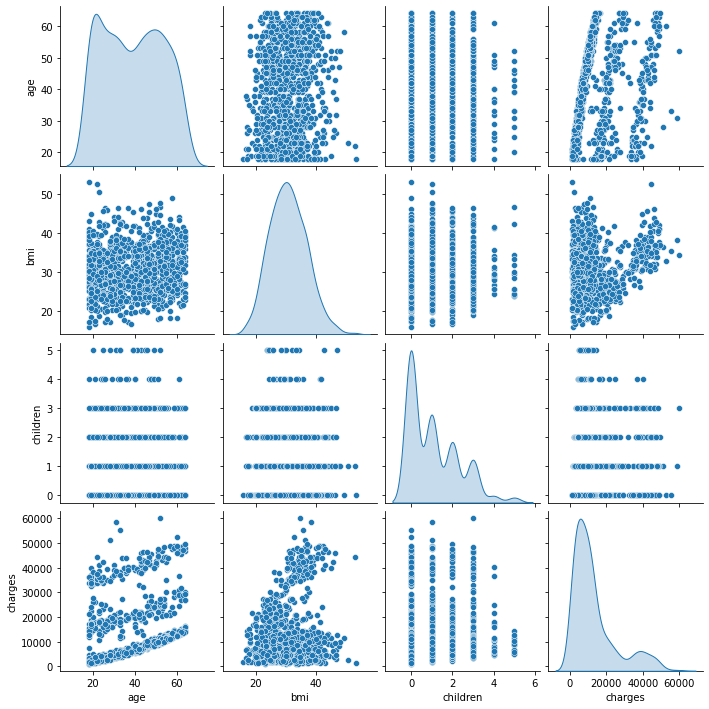

In [1]:
# import block
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
np.set_printoptions(precision=3, suppress=True)
 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
 
#### getting the data ####
 
url='http://drnam.org/pythonfiles/insurance.csv'
column_names=['age', 'sex','bmi','children','smoker','region','charges']
 
raw_dataset=pd.read_csv(url) #data is read
 
dataset=raw_dataset.copy() #data is copied to a easier name
 
#### data cleanup of non-numeric information irrelavent to charges ####
 
dataset['region'] = dataset['region'].map({1: 'southwest', 2: 'southeast', 3: 'northeast', 4: 'northwest'})
dataset['sex'] = dataset['sex'].map({1: 'male', 2: 'female'})
dataset['smoker'] = dataset['smoker'].map({1: 'yes', 2: 'no'})
 
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
 
#### split the data into train and test ####

train_dataset = dataset.sample(frac=0.8, random_state=0) #samples of data are taken and trained
test_dataset = dataset.drop(train_dataset.index) #sample are tested from data set
 
train_features = train_dataset.copy()
test_features = test_dataset.copy()
 
train_labels = train_features.pop('charges')
test_labels = test_features.pop('charges')
 
#### inspect the data ####
 
sns.pairplot(train_dataset[['age', 'bmi', 'children', 'charges']], diag_kind='kde')
 
train_dataset.describe().transpose()

In [6]:
#### split features from labels ####
 
train_features = train_dataset.copy()
test_features = test_dataset.copy()
 
train_labels = train_features.pop('charges')
test_labels = test_features.pop('charges')

In [7]:
#### normalization ####
 
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
 
print(normalizer.mean.numpy()) # calculates mean variance and stores
 
first = np.array(train_features[:1])
 
with np.printoptions(precision=2, suppress=True):
  print('\nFirst example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[[39.036 30.735  1.093]]

First example: [[52.  30.2  1. ]]

Normalized: [[ 0.92 -0.09 -0.08]]


In [14]:
#### linear regression ####
 
#### one variable ####
 
age = np.array(train_features['age']) #### building the age normalization layer #####
 
age_normalizer = preprocessing.Normalization(input_shape=[0])
#age_normalizer.adapt(age)
 
#### building the sequential model ####
 
age_model = tf.keras.Sequential([age_normalizer, layers.Dense(units=1)])
 
age_model.summary()
 
#### prediction made from the untrained model #####
 
age_model.predict(age[:10])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 0)                 1         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1         
Total params: 2
Trainable params: 1
Non-trainable params: 1
_________________________________________________________________


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [15]:
#### configuring the training layer ####
 
age_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')
 
#### executing the training ####
 
history = age_model.fit(train_features['age'], train_labels, epochs=100, verbose=0, validation_split = 0.2)
 
#### visualizing the model's training ####
 
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,12713.333984,14429.428711,95
96,12713.333008,14429.428711,96
97,12713.333008,14429.428711,97
98,12713.332031,14429.428711,98
99,12713.332031,14429.428711,99


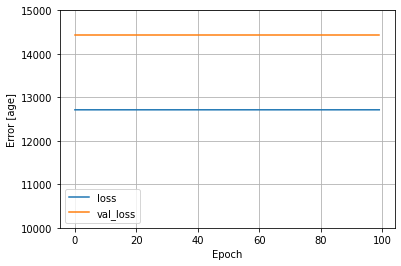

In [16]:
#### graphically ####
 
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([10000,15000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [age]')
  plt.legend()
  plt.grid(True)
 
plot_loss(history)

In [17]:
#### collecting the test results ####
 
test_results = {}
 
test_results['age_model'] = age_model.evaluate(test_features['age'], test_labels, verbose=0)

In [18]:
#### multiple inputs ####
 
#### normalization layer for the whole dataset ####
 
linear_model = tf.keras.Sequential([normalizer, layers.Dense(units=1)])
 
#### first 10 predictions ####
 
linear_model.predict(train_features[:10])

array([[ 0.979],
       [ 0.737],
       [-0.15 ],
       [-0.468],
       [ 2.018],
       [ 0.216],
       [-1.767],
       [ 1.558],
       [ 1.567],
       [ 0.907]], dtype=float32)

In [19]:
#### compile and fit the multiple input model similar to the single input model ####
 
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')
 
history = linear_model.fit(train_features, train_labels, epochs=100, verbose=0,validation_split=0.2)

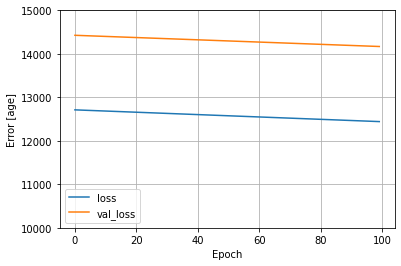

In [20]:
#### plot ####
 
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([10000,15000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [age]')
  plt.legend()
  plt.grid(True)
 
plot_loss(history)

In [21]:
#### save the test results #####
 
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

In [22]:
#### DNN regression ####
 
#### training procedure ####
 
def build_and_compile_model(norm):
  model = keras.Sequential([norm, layers.Dense(64, activation='relu'), layers.Dense(64, activation='relu'), layers.Dense(1)])
 
  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
 
  return model

In [23]:
#### one variable DNN regression using age ####

dnn_age_model = build_and_compile_model(age_normalizer)

dnn_age_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 0)                 1         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,290
Trainable params: 4,289
Non-trainable params: 1
_________________________________________________________________


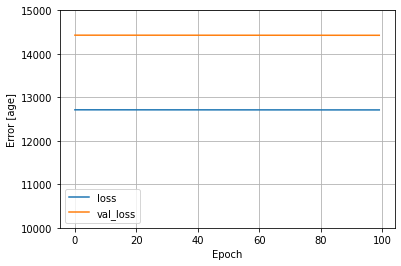

In [24]:
#### train the single variable model ####

history = dnn_age_model.fit(train_features['age'], train_labels, validation_split=0.2, verbose = 0, epochs=100)

#### plot ####

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([10000,15000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [age]')
  plt.legend()
  plt.grid(True)
 
plot_loss(history)

In [25]:
#### save the test results ####

test_results['dnn_age_model'] = dnn_age_model.evaluate(test_features['age'], test_labels, verbose = 0)

In [26]:
#### full model, repeat the process using all inputs ####

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


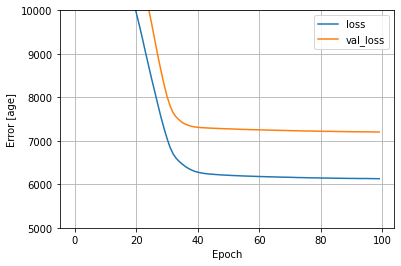

In [27]:
#### train model ####
# How is this wrong 
history = dnn_model.fit(train_features, train_labels, validation_split=0.2, verbose=0, epochs=100)
 
### plot ###
 
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([5000,10000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [age]')
  plt.legend()
  plt.grid(True)
 
plot_loss(history)

In [28]:
#### collect the test results ####

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [29]:
#### all the models are trained, now to check the test-set performance ####
 
pd.DataFrame(test_results, index=['Mean absolute error [charges]']).T

,Mean absolute error [charges]
age_model,14124.309570
linear_model,13856.056641
dnn_age_model,14121.609375
dnn_model,7185.804199


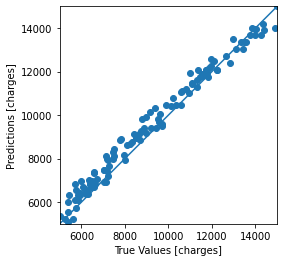

In [30]:
#### make predictions on the test set ####

test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [charges]')
plt.ylabel('Predictions [charges]')
lims = [5000,15000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

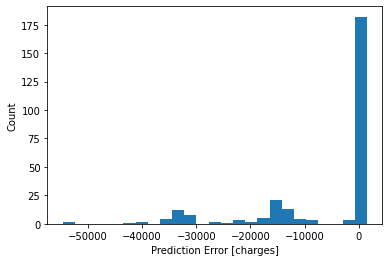

In [31]:
#### the error distribution ####
 
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [charges]')
_ = plt.ylabel('Count')

In [32]:
dnn_model.save('dnn_model') # save the model

INFO:tensorflow:Assets written to: dnn_model/assets
